# README

We are playing with code that would take data from the brain and assess if each point is MoX or BiX. The objective function used to select parameters will then ensure that the MoX points are fit with the MoX function while the biX points are fit with the biX function. This file looks at the 6p model across a log scale of TI value 

There are two important functions here
1: the function that evaluates data as biX or moX --> returns a list of biX or moX
2: the objective function equation

# Libraries

In [265]:
#Preparing all libraries
import matplotlib.pyplot as plt
import numpy as np
import scipy
from scipy.optimize import curve_fit
from scipy.optimize import minimize
import addcopyfighandler
import statistics
import math
import time
from tqdm import trange
from matplotlib import cm
import sklearn
from sklearn.cluster import KMeans
import colorsys
from datetime import date
import pickle
import functools

# Initialize Parameters

In [266]:
####### Options #######
randStart = False                  #Initial guess for parameter values in random locations

In [267]:
######All Fixed parameters for code
#Parameters held constant
T11 = 600
T12 = 1200
c1 = 0.3
c2 = 0.7 
T21 = 40
T22 = 100

true_params = np.array([c1, c2, T21, T22])

#Building the TE array - this should be a uniform array
n_points = 64
TE_step = 8

TE_DATA = np.linspace(TE_step, TE_step*n_points, n_points) #ms units

assert(TE_DATA[-1] == 512)
d_TE = np.mean(np.diff(TE_DATA))
assert(d_TE == 8)


######### TI list option if we want to use general points
#Building the TI array - this is a log spacing
# desired_TI_low = 100
# desired_TI_high = 2500
# TI_numpoints = 15
# TI_DATA = np.logspace(np.log10(desired_TI_low), np.log10(desired_TI_high), TI_numpoints)

######### TI list option if we want to use null points and a control point
TI_DATA = np.array([0, np.log(2)*T11, np.log(2)*T12])#(np.log(2)*T11 + np.log(2)*T12)/2])

#SNR Value to Evaluate
SNR_value = 100

#Parameters that dictate process related features
repetitions = 1000     #number of noise realizations averaged

cf_repetitions = 1   #number of times we compare minimize to curve_fit

#Curve Fit Trials - how many times do we run curve_fit before we take a parameter fit solution
if randStart:
    randStart_trials = 10
else:
    randStart_trials = 1

#Builds a string of parameters to use in the titles
ParamTitle_6p = ['T11','T12','c1','c2','T21','T22']
ParamTitle_4p = ['T11','T12','c1','c2','T21','T22']
round_Params = [round(num, 2) for num in true_params]
pList = ', '.join(str(x) for x in round_Params)
pTitleList = ', '.join(x for x in ParamTitle_6p) #Builds the list of parametes used to generate the original data

#### Important for Naming
date = date.today()
day = date.strftime('%d')
month = date.strftime('%B')[0:3]
year = date.strftime('%y')

In [268]:
#Defining the function of interest

def S_biX_6p(TE, c1, c2, T21, T22, TI = 0):
    exp1 = c1*(1-2*np.exp(-TI/T11))*np.exp(-TE/T21)
    exp2 = c2*(1-2*np.exp(-TI/T12))*np.exp(-TE/T22)
    return exp1 + exp2

#The ravel structure necessary for the curve_fit algorithm
def S_biX_6p_ravel(T_dat, c1, c2, T21, T22):
    TE, TI = T_dat
    exp1 = c1*(1-2*np.exp(-TI/T11))*np.exp(-TE/T21)
    exp2 = c2*(1-2*np.exp(-TI/T12))*np.exp(-TE/T22)
    return exp1 + exp2

def calculate_RSS_TI(func, popt, TI_val, data):
    est_curve = func(TE_DATA, *popt, TI = TI_val)
    RSS = np.sum((est_curve - data)**2)
    
    return RSS

#Defining the monoExp function of interest
def S_moX_3p_np1(TE, c, T2, TI = 0):
    return c*(1-2*np.exp(-TI/T11))*np.exp(-TE/T2)

def S_moX_3p_np2(TE, c, T2, TI = 0):
    return c*(1-2*np.exp(-TI/T12))*np.exp(-TE/T2)

#The one dimensional models are used to evaluate if a curve is more likely monoX or biX
def S_biX_4p(TE, d1, d2, T21, T22):
    exp1 = d1*np.exp(-TE/T21)
    exp2 = d2*np.exp(-TE/T22)
    return exp1 + exp2

def S_moX_2p(TE, d, T2):
    return d*np.exp(-TE/T2)

#All curves get noise according to this equation
def add_noise(data, SNR):
    #returns a noised vector of data using the SNR given
    sigma = (c1+c2)/SNR #np.max(np.abs(data))/SNR
    noise = np.random.normal(0,sigma,data.shape)
    noised_data = data + noise
    return noised_data

In [269]:
def get_func_bounds(func):
    f_name = func.__name__
    if f_name == "S_biX_6p":
        lower_bound = (0, 0, 1, 1)
        upper_bound = (1, 1, 300, 300)
    elif f_name == "S_moX_3p":
        lower_bound = (0, 1)
        upper_bound = (1, 300)
    elif f_name == "S_biX_4p":
        lower_bound = (-1, -1, 1, 1)
        upper_bound = (1, 1, 300, 300)
    elif f_name == "S_moX_2p":
        lower_bound = (-1, 1)
        upper_bound = (1, 300)
    else:
        raise Exception("Not a valid function: " + f_name)

    return lower_bound, upper_bound

def get_param_list(func):
    f_name = func.__name__
    if f_name.find("S_biX_6p") > -1:
        params = ("c1","c2","T21","T22")
    elif f_name.find("S_moX_3p") > -1:
        params = ("c","T2")
    else:
        raise Exception("Not a valid function: " + f_name)

    return params

def set_p0(func, random = True):
    true_params = [c1, c2, T21, T22]
    if random:
        lb, ub = get_func_bounds(func)
        if func.__name__.find("S_biX_6p") > -1:
            c1_est = np.random.uniform(lb[0],ub[0])
            T21_est = np.random.uniform(lb[-2],ub[-2])
            T22_est = np.random.uniform(lb[-1],ub[-1])
            p0 = [c1_est, 1-c1_est, T21_est, T22_est]
        else:
            p0 = [np.random.uniform(lb[i],ub[i]) for i in range(len(lb))]
    else:
        f_name = func.__name__
        if f_name.find("moX") > -1:
            p0 = [0.5, 80]
        elif f_name.find("biX") > -1:
            p0 = [0.5, 0.5, 60, 80]
        else:
            p0 = true_params
            
    return p0

def check_param_order(popt):
    #Reshaping of array to ensure that the parameter pairs all end up in the appropriate place - ensures that T22 > T21
    if (popt[-1] < popt[-2]): #We want by convention to make sure that T21 is <= T22
        for pi in range(np.size(popt)//2):
            p_hold = popt[2*pi]
            popt[2*pi] = popt[2*pi+1]
            popt[2*pi+1] = p_hold
    return popt

def calculate_RSS_TI(func, popt, TI_val, data):
    est_curve = func(TE_DATA, *popt, TI = TI_val)
    RSS = np.sum((est_curve - data)**2)
    
    return RSS

def calculate_RSS(func, popt, data):
    est_curve = func(TE_DATA, *popt)
    RSS = np.sum((est_curve - data)**2)
    
    return RSS

def estP_oneCurve(func, noisey_data):

    init_p = set_p0(func, random = True)
    lb, ub = get_func_bounds(func)

    popt, _ = curve_fit(func, TE_DATA, noisey_data, p0 = init_p, bounds = [lb,ub], method = 'trf', maxfev = 1500)
    popt = check_param_order(popt)
    RSS = calculate_RSS(func, popt, noisey_data)

    return popt, RSS

In [270]:
def BIC_opt1(RSS, TE_array, p_list, sigma):

    BIC = 1/len(TE_array) * (RSS + np.log(len(TE_array))*len(p_list)*(sigma)**2)

    return BIC

def BIC_opt2(RSS, TE_array, p_list):

    BIC = len(TE_array) * np.log(RSS/len(TE_array)) + len(p_list) * np.log(len(TE_array))

    return BIC

def evaluate_model(data):

    popt_biX, RSS_biX = estP_oneCurve(S_biX_4p, data)
    popt_moX, RSS_moX = estP_oneCurve(S_moX_2p, data)

    BIC_biX = BIC_opt2(RSS_biX, TE_DATA, popt_biX)
    BIC_moX = BIC_opt2(RSS_moX, TE_DATA, popt_moX)

    if BIC_moX < BIC_biX:
        return True, popt_moX, RSS_moX
    else:
        return False, popt_biX, RSS_biX


In [271]:
def objective_func(param_est, data_2d, TI_array, func_moX_np1 = S_moX_3p_np1, func_moX_np2 = S_moX_3p_np2, func_biX = S_biX_6p):
    # assert(data_2d.shape[0] == len(TI_array))

    curve_RSS_array = []

    for curve_iter in range(data_2d.shape[0]):
        TI_val = TI_array[curve_iter]
        data_1d = data_2d[curve_iter,:]
        moX_opt, curve_popt, curve_RSS = evaluate_model(data_1d)

        if moX_opt:
            np_1st = [param_est[-3], param_est[-1]]
            RSS_1st_np = calculate_RSS_TI(func_moX_np2, np_1st, TI_val, data_1d)

            np_2nd = [param_est[-4], param_est[-2]]
            RSS_2nd_np = calculate_RSS_TI(func_moX_np1, np_2nd, TI_val, data_1d)

            curve_RSS_array.append(np.min([RSS_1st_np, RSS_2nd_np]))

        else:
            RSS = calculate_RSS_TI(func_biX, param_est, TI_val, data_1d)

            curve_RSS_array.append(RSS)

    # print(f'{curve_RSS_array}')
    return np.sum(curve_RSS_array)

def conven_objective_func(param_est, data_2d, TI_array, func_biX = S_biX_6p):
    assert(data_2d.shape[0] == len(TI_array))

    curve_RSS_array = []

    for curve_iter in range(data_2d.shape[0]):
        TI_val = TI_array[curve_iter]
        data_1d = data_2d[curve_iter,:]

        RSS = calculate_RSS_TI(func_biX, param_est, TI_val, data_1d)

        curve_RSS_array.append(RSS)

    return np.sum(curve_RSS_array)

def objective_func_hc(param_est, data_2d, TI_array):
    # assert(data_2d.shape[0] == len(TI_array))

    curve_RSS = 0

    # moX_opt, curve_popt, curve_RSS = evaluate_model(data_2d[0,:])
    # assert(not moX_opt)
    # moX_opt, curve_popt, curve_RSS = evaluate_model(data_2d[1,:])
    # assert(moX_opt)
    # moX_opt, curve_popt, curve_RSS = evaluate_model(data_2d[2,:])
    # assert(moX_opt)

    curve_RSS += calculate_RSS_TI(S_biX_6p, param_est, TI_array[0], data_2d[0,:])
    curve_RSS += calculate_RSS_TI(S_moX_3p_np2, [param_est[-3], param_est[-1]], TI_array[1], data_2d[1,:])
    curve_RSS += calculate_RSS_TI(S_moX_3p_np1, [param_est[-4], param_est[-2]], TI_array[2], data_2d[2,:])

    return curve_RSS

def conven_objective_func_hc(param_est, data_2d, TI_array):
    # assert(data_2d.shape[0] == len(TI_array))

    curve_RSS = 0


    curve_RSS += calculate_RSS_TI(S_biX_6p, param_est, TI_array[0], data_2d[0,:])
    curve_RSS += calculate_RSS_TI(S_biX_6p, param_est, TI_array[1], data_2d[1,:])
    curve_RSS += calculate_RSS_TI(S_biX_6p, param_est, TI_array[2], data_2d[2,:])

    return curve_RSS

def list_objective_func(param_est, data_2d, TI_array, X_list):
    assert(data_2d.shape[0] == len(TI_array))
    assert(len(X_list) == len(TI_array))

    curve_RSS = 0

    X_truth = [elem == "BiX" for elem in X_list]

    for iter in range(len(X_truth)):
        if X_truth[iter]:
            RSS_add = calculate_RSS_TI(S_biX_6p, param_est, TI_array[iter], data_2d[iter,:])
        else:
            RSS_opt1 = calculate_RSS_TI(S_moX_3p_np2, [param_est[-3], param_est[-1]], TI_array[iter], data_2d[iter,:])
            RSS_opt2 = calculate_RSS_TI(S_moX_3p_np1, [param_est[-4], param_est[-2]], TI_array[iter], data_2d[iter,:])
            RSS_add = np.min([RSS_opt1, RSS_opt2])

        curve_RSS += RSS_add

    return curve_RSS

def RSS_obj_func(popt, data, TI_val, func):
    est_curve = func(TE_DATA, *popt, TI = TI_val)
    RSS = np.sum((est_curve - data)**2)
    
    return RSS

def callbackF(Xi, data, TI_array):
    global Nfeval
    print('{0:4d}   {1: 3.6f}   {2: 3.6f}   {3: 3.6f}'.format(Nfeval, Xi[-4], Xi[-3], objective_func(Xi, data, TI_array)))
    Nfeval += 1


In [272]:
def get_hist_index(param_label):
    if param_label[-1] == '2':
        row = 1
    else:
        row = 0

    if param_label[:-1] == "c":
        col = 0
    else:
        col = 1

    return row, col

def get_label_range(param_label):
    if param_label.find("T2") > -1:
        return 10
    elif param_label.find("c") > -1:
        return 0.1
    else:
        return 100

def calc_MSE(paramStore, true_params, clipped = False):
    varMat = np.var(paramStore, axis=0)
    biMat = np.mean(paramStore, axis = 0) - true_params  #E[p_hat] - p_true
    MSEMat = varMat + biMat**2
    if clipped:
        return MSEMat[-4:], biMat[-4:], varMat[-4:]
    return MSEMat, biMat, varMat

def parameter_histogram(paramStore, true_params, func, add_title, good_range = False):
    fig, ax = plt.subplots(2, 2, figsize=(8,5.5), tight_layout=True)
    fig.suptitle(add_title)

    labels = get_param_list(func)
    lb, ub = get_func_bounds(func)

    MSEMat, _, _ = calc_MSE(paramStore, true_params)

    for ii in range(paramStore.shape[1]):

        row, col = get_hist_index(labels[ii])

        #Construct a nice figure of each of the two 

        
        if good_range:
            order_of_p = get_label_range(labels[ii])
            lower_p = true_params[ii] - order_of_p
            upper_p = true_params[ii] + order_of_p
            binwidth = order_of_p/20
            dist_p = np.arange(lower_p, upper_p+order_of_p/10, binwidth)

            ax[row, col].hist(x=paramStore[:,ii], bins=dist_p, color='b', label = labels[ii], alpha = 0.7)
            ax[row, col].set_xlabel('Param Value')
            ax[row, col].set_ylabel('Count')
            ax[row, col].axvline(x=true_params[ii], linewidth=1, label= 'True ' + labels[ii], color='black')
            ax[row, col].axvline(x=np.mean(paramStore[:,ii]), linewidth=1, label= 'Avg ' + labels[ii], color='red', ls = "--")

            ax[row, col].set_xlim([lower_p, upper_p])
            low_count = np.sum(paramStore[:,ii] < lower_p)
            high_count = np.sum(paramStore[:,ii] > upper_p)

            ax[row, col].set_title('True ' + labels[ii] + '=' + "{:.2f}".format(true_params[ii]) + 
                    '\nMSE(' + labels[ii] + ') = ' + "{:.2e}".format(MSEMat[ii]) +
                    f'\nOutliers: {low_count} Below & {high_count} Above')

        else:
            ax[row, col].hist(x=paramStore[:,ii], bins=20, color='b', label = labels[ii], alpha = 0.7)
            ax[row, col].set_xlabel('Param Value')
            ax[row, col].set_ylabel('Count')
            ax[row, col].axvline(x=true_params[ii], linewidth=1, label= 'True ' + labels[ii], color='black')
            ax[row, col].axvline(x=np.mean(paramStore[:,ii]), linewidth=1, label= 'Avg ' + labels[ii], color='red', ls = "--")
            ax[row, col].set_xlim([lb[ii], ub[ii]])
            ax[row, col].set_title('True ' + labels[ii] + '=' + "{:.2f}".format(true_params[ii]) + 
                    '\nMSE(' + labels[ii] + ') = ' + "{:.2e}".format(MSEMat[ii]))

        ax[row, col].legend()
        ax[row, col].ticklabel_format(useOffset=False, style='scientific')

    plt.show()
    return

# Check Curve Fit vs. Minimize

In [273]:
TI_value = 0

biX_sig = S_biX_6p(TE_DATA, *true_params, TI_value)

noise_test = add_noise(biX_sig, SNR_value)

init_p = set_p0(S_biX_6p, random = True)

lb, ub = get_func_bounds(S_biX_6p)
bnd_cat = [lb,ub]
bnd_cat = np.array(bnd_cat)
bnd_cat = np.transpose(bnd_cat)
bnds = bnd_cat.tolist()

# This uses curve fit to look for optimal params
popt, _ = curve_fit(functools.partial(S_biX_6p, TI = TI_value), TE_DATA, noise_test, p0 = init_p, bounds = [lb,ub], method = 'trf', maxfev = 1500)
popt = check_param_order(popt)
RSS = calculate_RSS_TI(S_biX_6p, popt, TI_value, noise_test)

#reshaping the bounds for the minimization function

res = minimize(RSS_obj_func, init_p, args = (noise_test, TI_value, S_biX_6p), method = 'Powell', bounds = bnds, options = {'maxiter': 1000, 'disp': True})
min_popt = check_param_order(res.x)
min_RSS = res.fun

print("Comparison of Curve Fit and Minimize with RSS obj. func.")
print(f"Curve Fit :: popt = {popt} :: RSS = {RSS:.4f}")
print(f"Minimize :: popt = {min_popt} :: RSS = {min_RSS:.4f}")

Optimization terminated successfully.
         Current function value: 0.007170
         Iterations: 8
         Function evaluations: 393
Comparison of Curve Fit and Minimize with RSS obj. func.
Curve Fit :: popt = [ 0.27644013  0.7301438  32.14259853 99.96510538] :: RSS = 0.0068
Minimize :: popt = [ 0.18779981  0.82394014 22.38464587 93.53475716] :: RSS = 0.0072


In [274]:
param_est_curve_fit = np.zeros((cf_repetitions,len(true_params)))
RSS_curve_fit = np.zeros(cf_repetitions)

param_est_min = np.zeros((cf_repetitions,len(true_params)))
RSS_min = np.zeros(cf_repetitions)


for rep in trange(cf_repetitions):
    #Note that lb, ub, and the true signal only has to be calculated once

    noise_test = add_noise(biX_sig, SNR_value)

    init_p = set_p0(S_biX_6p, random = True)

    # This uses curve fit to look for optimal params
    popt, _ = curve_fit(functools.partial(S_biX_6p, TI = TI_value), TE_DATA, noise_test, p0 = init_p, bounds = [lb,ub], method = 'trf', maxfev = 1500)
    popt = check_param_order(popt)
    RSS = calculate_RSS_TI(S_biX_6p, popt, TI_value, noise_test)
    param_est_curve_fit[rep,:] = popt
    RSS_curve_fit[rep] = RSS

    #reshaping the bounds for the minimization function

    res = minimize(RSS_obj_func, init_p, args = (noise_test, TI_value, S_biX_6p), method = 'Powell', bounds = bnds, options = {'maxiter': 1000, 'disp': False})
    min_popt = check_param_order(res.x)
    min_RSS = res.fun
    param_est_min[rep,:] = min_popt
    RSS_min[rep] = min_RSS

100%|██████████| 1/1 [00:00<00:00,  8.17it/s]


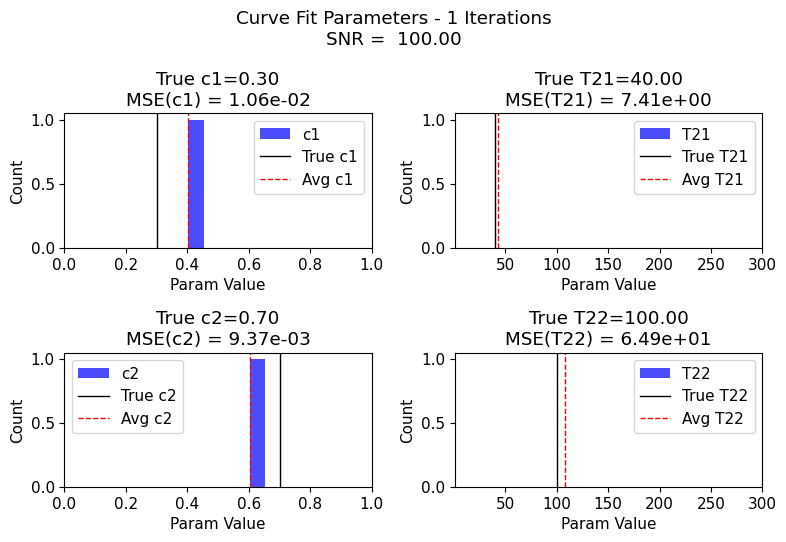

In [275]:
title_hold = f"Curve Fit Parameters - {cf_repetitions} Iterations\nSNR = {SNR_value : 0.2f}"
plt.rc('font', size = 11)
parameter_histogram(param_est_curve_fit, true_params, S_biX_6p, title_hold)

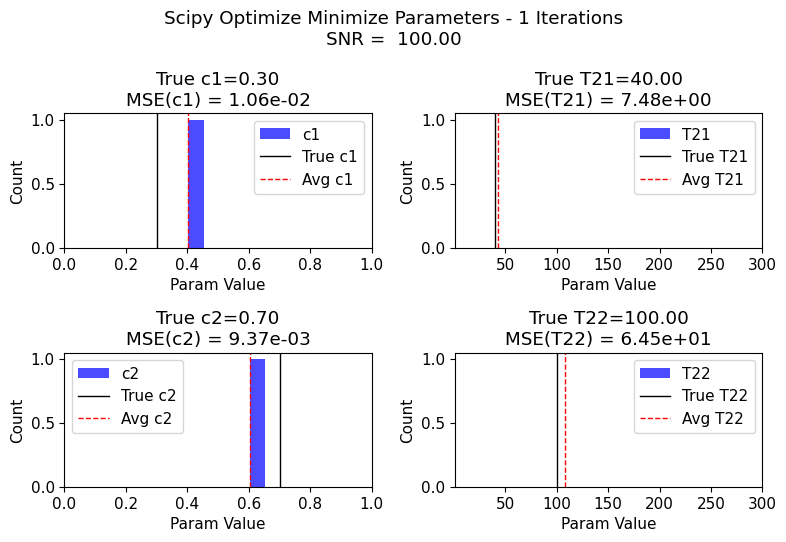

In [276]:
title_hold = f"Scipy Optimize Minimize Parameters - {cf_repetitions} Iterations\nSNR = {SNR_value : 0.2f}"
plt.rc('font', size = 11)
parameter_histogram(param_est_min, true_params, S_biX_6p, title_hold)

# Data Processing

In [277]:
biX_data = S_biX_6p(TE_DATA, *true_params, TI = TI_DATA[0])
moX_data1 = S_biX_6p(TE_DATA, *true_params, TI = TI_DATA[1])
moX_data2 = S_biX_6p(TE_DATA, *true_params, TI = TI_DATA[2])

all_data = np.stack((biX_data, moX_data1, moX_data2), axis = 0)

noised_data = add_noise(all_data, SNR_value)

assert(noised_data.shape[0] == 3)

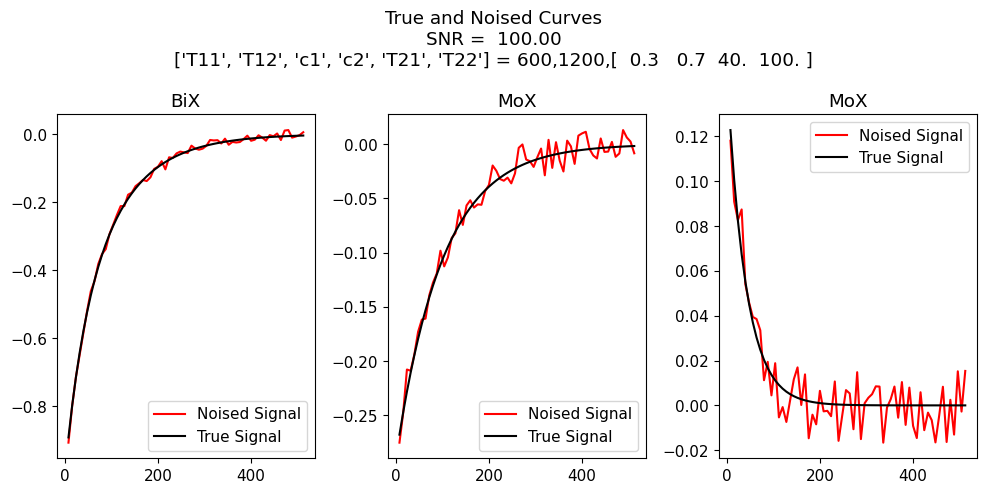

In [278]:
fig, ax = plt.subplots(1,3, figsize=(10,5), tight_layout=True)
fig.suptitle(f"True and Noised Curves\nSNR = {SNR_value : 0.2f}\n{ParamTitle_6p} = {T11},{T12},{true_params}")
title_array = ['BiX','MoX','MoX']
for i in range(3):
    ax[i].plot(TE_DATA, noised_data[i,:], color = 'r', label = 'Noised Signal')
    ax[i].plot(TE_DATA, S_biX_6p(TE_DATA, *true_params, TI = TI_DATA[i]), color = 'k', label = 'True Signal')
    ax[i].legend()
    ax[i].set_title(title_array[i])

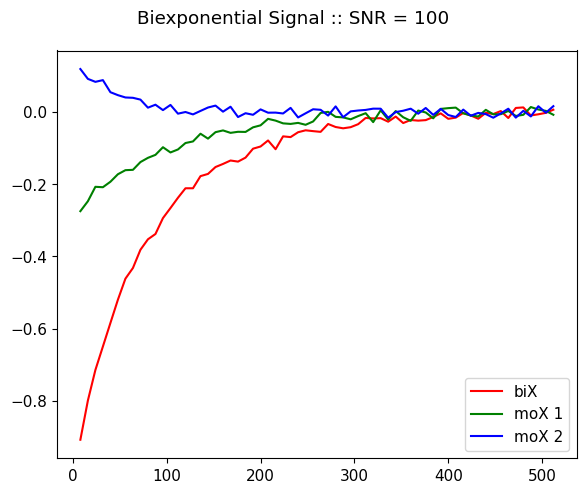

In [279]:
fig, ax = plt.subplots(1,1, figsize=(6,5), tight_layout=True)
fig.suptitle(f'Biexponential Signal :: SNR = {SNR_value}')
ax.plot(TE_DATA, noised_data[0,:], color = 'r', label = 'biX')
ax.plot(TE_DATA, noised_data[1,:], color = 'g', label = 'moX 1')
ax.plot(TE_DATA, noised_data[2,:], color = 'b', label = 'moX 2')
ax.legend()

In [280]:
data_truth = ["biX", "moX", "moX"]

print(f'True parameters of {ParamTitle_4p} are {true_params}\n')

for i in range(noised_data.shape[0]):
    moX_data, popt_params, RSS_opt = evaluate_model(noised_data[i,:])
    print(f'Data of type {data_truth[i]} was evaluate as {moX_data} for the moX model')
    print(f'Opt Params are determined as {popt_params} with RSS of {RSS_opt}\n')

True parameters of ['T11', 'T12', 'c1', 'c2', 'T21', 'T22'] are [  0.3   0.7  40.  100. ]

Data of type biX was evaluate as False for the moX model
Opt Params are determined as [-0.28265453 -0.73859168 34.3456517  97.48013906] with RSS of 0.0042657319109629666

Data of type moX was evaluate as True for the moX model
Opt Params are determined as [-0.28819849 99.0463955 ] with RSS of 0.005516197702084446

Data of type moX was evaluate as True for the moX model
Opt Params are determined as [ 0.14677226 41.35424509] with RSS of 0.0058316030648065485



In [281]:
moX_opt_biX = []
for iter in trange(1000):
    mox_opt_iter, _, _ = evaluate_model(noised_data[0,:])
    moX_opt_biX.append(mox_opt_iter)

moX_opt1 = []
for iter in trange(1000):
    mox_opt_iter, _, _ = evaluate_model(noised_data[1,:])
    moX_opt1.append(mox_opt_iter)

moX_opt2 = []
for iter in trange(1000):
    mox_opt_iter, _, _ = evaluate_model(noised_data[2,:])
    moX_opt2.append(mox_opt_iter)

100%|██████████| 1000/1000 [00:41<00:00, 24.04it/s]


In [282]:
print(f"True Parameters = {T11}, {T12}, {true_params}")
print(f"SNR = {SNR_value}")

print("\nBiexponential Data")
print(f"Monoexponential {np.sum(moX_opt_biX)} times of {1000}")
print(f"Biexponential {1000 - np.sum(moX_opt_biX)} times of {1000}")

print("\nMonoexponential Data 1")
print(f"Monoexponential {np.sum(moX_opt1)} times of {1000}")
print(f"Biexponential {1000 - np.sum(moX_opt1)} times of {1000}")

print("\nMonoexponential Data 2")
print(f"Monoexponential {np.sum(moX_opt2)} times of {1000}")
print(f"Biexponential {1000 - np.sum(moX_opt2)} times of {1000}")

True Parameters = 600, 1200, [  0.3   0.7  40.  100. ]
SNR = 100

Biexponential Data
Monoexponential 2 times of 1000
Biexponential 998 times of 1000

Monoexponential Data 1
Monoexponential 1000 times of 1000
Biexponential 0 times of 1000

Monoexponential Data 2
Monoexponential 1000 times of 1000
Biexponential 0 times of 1000


In [283]:
init_p = set_p0(S_biX_6p, random = True)

#reshaping the bounds for the minimization function
lb, ub = get_func_bounds(S_biX_6p)
bnd_cat = [lb,ub]
bnd_cat = np.array(bnd_cat)
bnd_cat = np.transpose(bnd_cat)
bnds = bnd_cat.tolist()


# init_p = true_params
print("Initial Guess")
print(init_p)

# cons = ({'type': 'ineq', 'fun': lambda x:  x[-3] - x[-2]}) #the goal is to be non negative - this ensures that x[-3] > x[-2]
# callback = lambda pDat:callbackF(pDat, noised_data, TI_DATA)
# Nfeval = 1
# print('{0:4s}   {1:9s}   {2:9s}   {3:9s}'.format('Iter', ' c1', ' c2', 'f(X)'))

# RSS_Val = objective_func_hc(init_p, noised_data, TI_DATA)

print("\nBIC Model")
res_BIC = minimize(objective_func_hc, init_p, args = (noised_data, TI_DATA), method = 'Nelder-Mead', bounds = bnds, options = {'maxiter': 1000, 'disp': True})
popt_BIC = check_param_order(res_BIC.x)
print(popt_BIC)

print("\nConventional Model")
res_conven = minimize(conven_objective_func_hc, init_p, args = (noised_data, TI_DATA), method = 'Nelder-Mead', bounds = bnds, options = {'maxiter': 1000, 'disp': True})
popt_conven = check_param_order(res_conven.x)
print(popt_conven)


Initial Guess
[0.9111272130732415, 0.08887278692675848, 225.07487697948687, 24.76953911240228]

BIC Model
Optimization terminated successfully.
         Current function value: 0.015757
         Iterations: 243
         Function evaluations: 416
[ 0.31031777  0.70034311 39.2152065  99.14549266]

Conventional Model
Optimization terminated successfully.
         Current function value: 0.015757
         Iterations: 243
         Function evaluations: 416
[ 0.31031777  0.70034311 39.2152065  99.14549266]


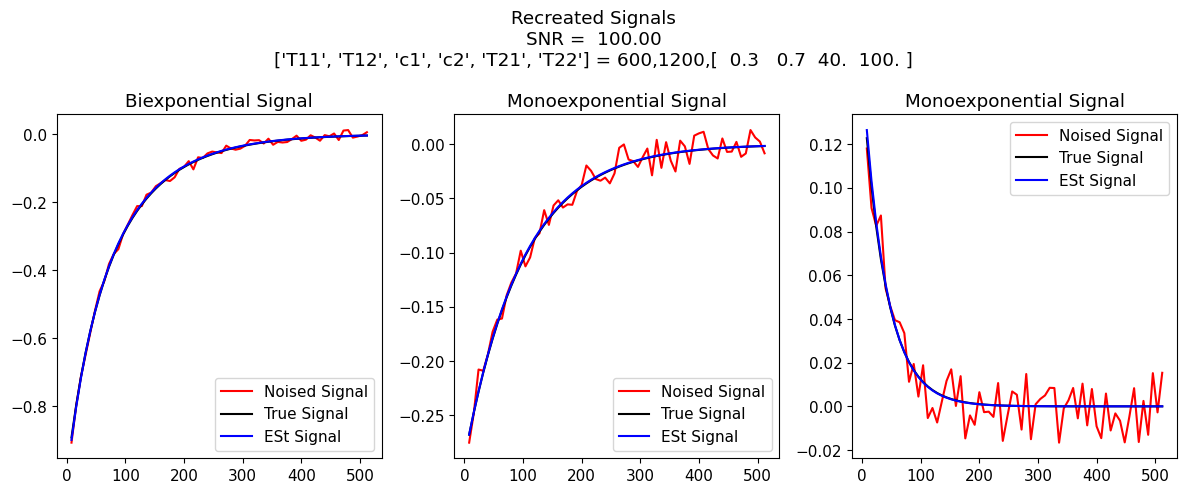

In [284]:
fig, ax = plt.subplots(1,3, figsize=(12,5), tight_layout=True)
fig.suptitle(f"Recreated Signals\nSNR = {SNR_value : 0.2f}\n{ParamTitle_6p} = {T11},{T12},{true_params}")
ax[0].set_title(f'Biexponential Signal')
ax[0].plot(TE_DATA, noised_data[0,:], color = 'r', label = 'Noised Signal')
ax[0].plot(TE_DATA, S_biX_6p(TE_DATA, *true_params, TI = TI_DATA[0]), color = 'k', label = 'True Signal')
ax[0].plot(TE_DATA, S_biX_6p(TE_DATA, *res_BIC.x, TI = TI_DATA[0]), color = 'b', label = 'ESt Signal')
ax[0].legend()

ax[1].set_title(f'Monoexponential Signal')
ax[1].plot(TE_DATA, noised_data[1,:], color = 'r', label = 'Noised Signal')
ax[1].plot(TE_DATA, S_biX_6p(TE_DATA, *true_params, TI = TI_DATA[1]), color = 'k', label = 'True Signal')
ax[1].plot(TE_DATA, S_biX_6p(TE_DATA, *res_BIC.x, TI = TI_DATA[1]), color = 'b', label = 'ESt Signal')
ax[1].legend()

ax[2].set_title(f'Monoexponential Signal')
ax[2].plot(TE_DATA, noised_data[2,:], color = 'r', label = 'Noised Signal')
ax[2].plot(TE_DATA, S_biX_6p(TE_DATA, *true_params, TI = TI_DATA[2]), color = 'k', label = 'True Signal')
ax[2].plot(TE_DATA, S_biX_6p(TE_DATA, *res_BIC.x, TI = TI_DATA[2]), color = 'b', label = 'ESt Signal')
ax[2].legend()

In [285]:
init_p = set_p0(S_biX_6p, random = True)

#reshaping the bounds for the minimization function
mTE, mTI = np.meshgrid(TE_DATA, TI_DATA)

vecT = np.vstack((mTE.ravel(), mTI.ravel())) #flattens the data points
vecS = noised_data.ravel()

print("Initial Guess")
print(init_p)

# cons = ({'type': 'ineq', 'fun': lambda x:  x[-3] - x[-2]}) #the goal is to be non negative - this ensures that x[-3] > x[-2]
# callback = lambda pDat:callbackF(pDat, noised_data, TI_DATA)
# Nfeval = 1
# print('{0:4s}   {1:9s}   {2:9s}   {3:9s}'.format('Iter', ' c1', ' c2', 'f(X)'))
popt, _ = curve_fit(S_biX_6p_ravel, vecT, vecS, p0 = init_p, bounds = [lb, ub], method = 'trf', maxfev = 1500)

popt = check_param_order(popt)
print(popt)

Initial Guess
[0.8905914345837012, 0.10940856541629884, 269.3368598225132, 285.146033927178]
[ 0.31031753  0.70034336 39.21521491 99.14544992]


# Many Repetitions

In [286]:
biX_data = S_biX_6p(TE_DATA, *true_params, TI = TI_DATA[0])
moX_data1 = S_biX_6p(TE_DATA, *true_params, TI = TI_DATA[1])
moX_data2 = S_biX_6p(TE_DATA, *true_params, TI = TI_DATA[2])

all_data = np.stack((biX_data, moX_data1, moX_data2), axis = 0)

In [287]:
param_est_BIC = np.zeros((repetitions,len(true_params)))
n_evals_BIC = np.zeros(repetitions)
fval_BIC = np.zeros(repetitions)
nfev_BIC = np.zeros(repetitions)

param_est_cvn = np.zeros((repetitions,len(true_params)))
n_evals_cvn = np.zeros(repetitions)
fval_cvn = np.zeros(repetitions)
nfev_cvn = np.zeros(repetitions)

param_est_cF = np.zeros((repetitions,len(true_params)))
fval_cF = np.zeros(repetitions)

#reshaping the bounds for the minimization function
lb, ub = get_func_bounds(S_biX_6p)
bnd_cat = [lb,ub]
bnd_cat = np.array(bnd_cat)
bnd_cat = np.transpose(bnd_cat)
bnds = bnd_cat.tolist()

#Building the ravel arrays for the curve_fit comparison
mTE, mTI = np.meshgrid(TE_DATA, TI_DATA)

vecT = np.vstack((mTE.ravel(), mTI.ravel())) #flattens the data points


for rep in trange(repetitions):

    init_p = true_params #set_p0(S_biX_6p, random = True)
    noised_data = add_noise(all_data, SNR_value)

    res = minimize(objective_func_hc, init_p, args = (noised_data, TI_DATA), method = 'Nelder-Mead', bounds = bnds, options = {'maxiter': 1500, 'disp': False})
    param_est_BIC[rep,:] = check_param_order(res.x)
    n_evals_BIC[rep] = res.nit
    fval_BIC[rep] = res.fun
    nfev_BIC[rep] = res.nfev

    res = minimize(conven_objective_func_hc, init_p, args = (noised_data, TI_DATA), method = 'Nelder-Mead', bounds = bnds, options = {'maxiter': 1500, 'disp': False})
    param_est_cvn[rep,:] = check_param_order(res.x)
    n_evals_cvn[rep] = res.nit
    fval_cvn[rep] = res.fun
    nfev_cvn[rep] = res.nfev

    vecS = noised_data.ravel()
    popt, _ = curve_fit(S_biX_6p_ravel, vecT, vecS, p0 = init_p, bounds = [lb, ub], method = 'trf', maxfev = 1500)
    param_est_cF[rep,:] = check_param_order(popt)
    RSS_cF_array = []
    for iter in range(noised_data.shape[0]):
        RSS_cF_array.append(calculate_RSS_TI(S_biX_6p, popt, TI_DATA[iter], noised_data[iter,:]))

    fval_cF[rep] = np.sum(RSS_cF_array)


    

  0%|          | 2/1000 [00:00<01:02, 16.02it/s]

100%|██████████| 1000/1000 [00:36<00:00, 27.77it/s]


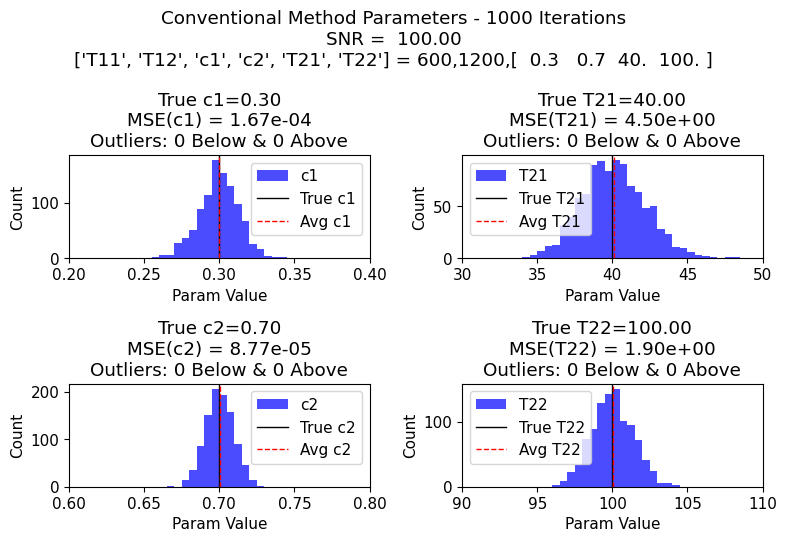

In [288]:
title_hold = f"Conventional Method Parameters - {repetitions} Iterations\nSNR = {SNR_value : 0.2f}\n{ParamTitle_6p} = {T11},{T12},{true_params}"
plt.rc('font', size = 11)
parameter_histogram(param_est_cvn, true_params, S_biX_6p, title_hold, good_range = True)

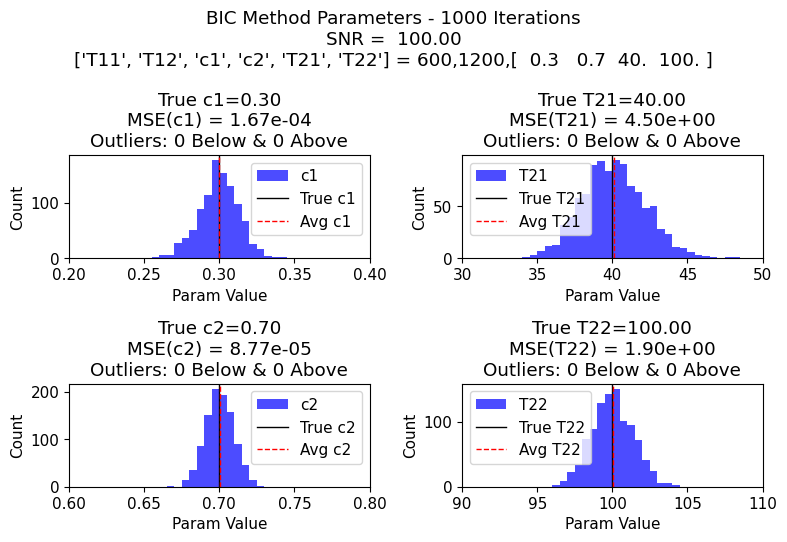

In [289]:
title_hold = f"BIC Method Parameters - {repetitions} Iterations\nSNR = {SNR_value : 0.2f}\n{ParamTitle_6p} = {T11},{T12},{true_params}"
plt.rc('font', size = 11)
parameter_histogram(param_est_BIC, true_params, S_biX_6p, title_hold, good_range = True)

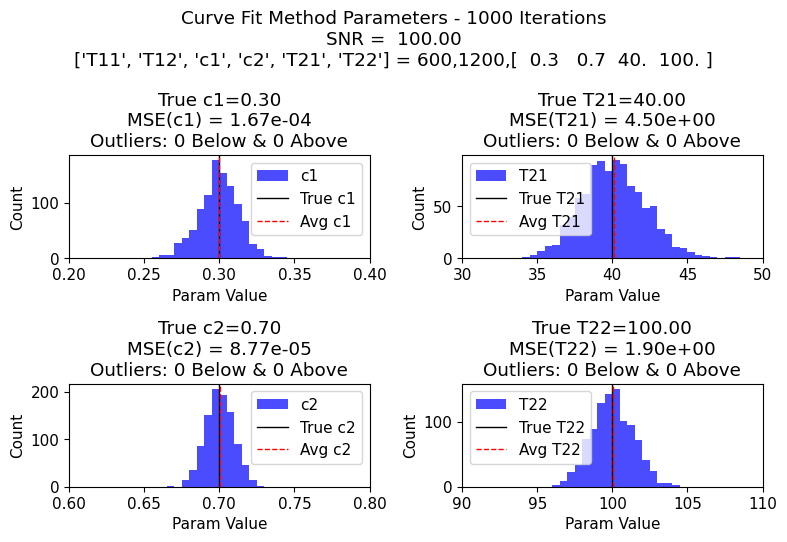

In [290]:
title_hold = f"Curve Fit Method Parameters - {repetitions} Iterations\nSNR = {SNR_value : 0.2f}\n{ParamTitle_6p} = {T11},{T12},{true_params}"
plt.rc('font', size = 11)
parameter_histogram(param_est_cF, true_params, S_biX_6p, title_hold, good_range = True)

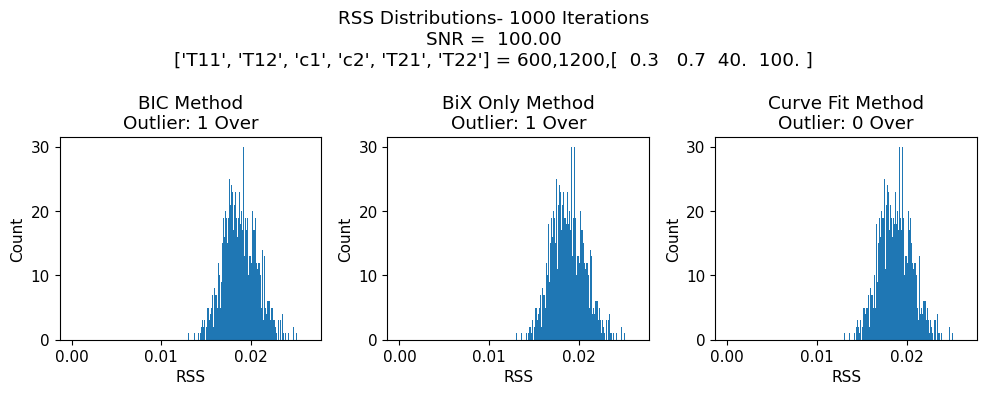

In [291]:
fig, ax = plt.subplots(1,3, figsize=(10,4), tight_layout=True)
fig.suptitle(f"RSS Distributions- {repetitions} Iterations\nSNR = {SNR_value : 0.2f}\n{ParamTitle_6p} = {T11},{T12},{true_params}")

bin_top = np.max(fval_cF)
bin_width = 10**(np.floor(np.log10(bin_top))-2)
bin_array = np.arange(0, bin_top, bin_width)

ax[0].hist(x = fval_BIC, bins = bin_array)
ax[0].set_title(f"BIC Method\nOutlier: {np.sum(fval_BIC > bin_top)} Over")
ax[0].set_xlabel('RSS')
ax[0].set_ylabel('Count')

ax[1].hist(x = fval_cvn, bins = bin_array)
ax[1].set_title(f"BiX Only Method\nOutlier: {np.sum(fval_cvn > bin_top)} Over")
ax[1].set_xlabel('RSS')
ax[1].set_ylabel('Count')

ax[2].hist(x = fval_cF, bins = bin_array)
ax[2].set_title(f"Curve Fit Method\nOutlier: {np.sum(fval_cF > bin_top)} Over")
ax[2].set_xlabel('RSS')
ax[2].set_ylabel('Count')

plt.show()

# Number of Signals Experiment

In [292]:
TI_DATA_var = np.array([0, np.log(2)*T11, np.log(2)*T12])#
X_array_real = ["BiX", "MoX", "MoX"]
X_array_default = ["BiX" for iter in X_array_real]
var_reps = 500
true_params = [0.3,0.7,40,60]

signal_array = np.zeros([len(TI_DATA_var), len(TE_DATA)])

for iTI in range(len(TI_DATA_var)):
    signal_array[iTI,:] = S_biX_6p(TE_DATA, *true_params, TI = TI_DATA_var[iTI])

print(f"Real Behavior: {X_array_real}")
print(f"Default Behavior: {X_array_default}")

Real Behavior: ['BiX', 'MoX', 'MoX']
Default Behavior: ['BiX', 'BiX', 'BiX']


In [293]:
param_est_BIC = np.zeros((var_reps, len(true_params)))
n_evals_BIC = np.zeros(var_reps)
fval_BIC = np.zeros(var_reps)
nfev_BIC = np.zeros(var_reps)

param_est_cvn = np.zeros((var_reps, len(true_params)))
n_evals_cvn = np.zeros(var_reps)
fval_cvn = np.zeros(var_reps)
nfev_cvn = np.zeros(var_reps)

param_est_cF = np.zeros((var_reps, len(true_params)))
fval_cF = np.zeros(var_reps)

#reshaping the bounds for the minimization function
lb, ub = get_func_bounds(S_biX_6p)
bnd_cat = [lb,ub]
bnd_cat = np.array(bnd_cat)
bnd_cat = np.transpose(bnd_cat)
bnds = bnd_cat.tolist()

#Building the ravel arrays for the curve_fit comparison
mTE, mTI = np.meshgrid(TE_DATA, TI_DATA_var)

vecT = np.vstack((mTE.ravel(), mTI.ravel())) #flattens the data points


for rep in trange(var_reps):

    init_p = set_p0(S_biX_6p, random = True)
    noised_data = add_noise(signal_array, SNR_value)

    res = minimize(list_objective_func, init_p, args = (noised_data, TI_DATA_var, X_array_real), method = 'Nelder-Mead', bounds = bnds, options = {'maxiter': 1500, 'disp': False})
    param_est_BIC[rep,:] = check_param_order(res.x)
    n_evals_BIC[rep] = res.nit
    fval_BIC[rep] = res.fun
    nfev_BIC[rep] = res.nfev

    res = minimize(list_objective_func, init_p, args = (noised_data, TI_DATA_var, X_array_default), method = 'Nelder-Mead', bounds = bnds, options = {'maxiter': 1500, 'disp': False})
    param_est_cvn[rep,:] = check_param_order(res.x)
    n_evals_cvn[rep] = res.nit
    fval_cvn[rep] = res.fun
    nfev_cvn[rep] = res.nfev

    vecS = noised_data.ravel()
    popt, _ = curve_fit(S_biX_6p_ravel, vecT, vecS, p0 = init_p, bounds = [lb, ub], method = 'trf', maxfev = 1500)
    param_est_cF[rep,:] = check_param_order(popt)
    RSS_cF_array = []
    for iter in range(noised_data.shape[0]):
        RSS_cF_array.append(calculate_RSS_TI(S_biX_6p, popt, TI_DATA[iter], noised_data[iter,:]))

    fval_cF[rep] = np.sum(RSS_cF_array)


    

100%|██████████| 500/500 [01:13<00:00,  6.76it/s]


(1.0, 300.0)

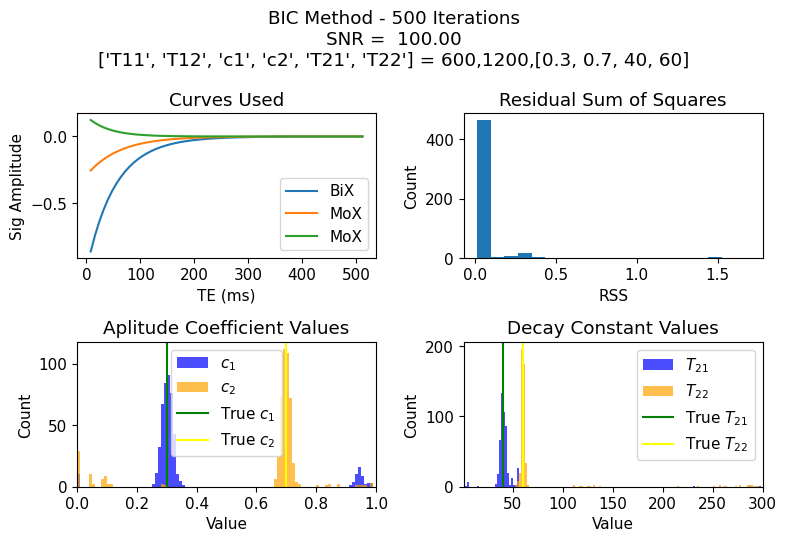

In [294]:
fig, ax = plt.subplots(2, 2, figsize=(8,5.5), tight_layout=True)
fig.suptitle(f"BIC Method - {var_reps} Iterations\nSNR = {SNR_value : 0.2f}\n{ParamTitle_6p} = {T11},{T12},{true_params}")

labels = get_param_list(S_biX_6p)
lb, ub = get_func_bounds(S_biX_6p)

MSEMat, varMat, sqBMat = calc_MSE(param_est_BIC, true_params)

for ii in range(len(X_array_real)):
    ax[0,0].plot(TE_DATA, signal_array[ii,:], label = X_array_real[ii])
ax[0,0].legend()
ax[0,0].set_xlabel("TE (ms)")
ax[0,0].set_ylabel("Sig Amplitude")
ax[0,0].set_title("Curves Used")

ax[0,1].hist(x = fval_BIC, bins = 20)
ax[0,1].set_xlabel('RSS')
ax[0,1].set_ylabel('Count')
ax[0,1].set_title("Residual Sum of Squares")

bin_array = np.arange(0, 1, 0.01)
ax[1,0].hist(x=param_est_BIC[:,0], bins=bin_array, color='b', label = r'$c_{1}$', alpha = 0.7)
ax[1,0].hist(x=param_est_BIC[:,1], bins=bin_array, color='orange', label = r'$c_{2}$', alpha = 0.7)
ax[1,0].axvline(x = true_params[0], label = r'True $c_{1}$', color='g')
ax[1,0].axvline(x = true_params[1], label = r'True $c_{2}$', color='yellow')
ax[1,0].legend()
ax[1,0].set_xlabel('Value')
ax[1,0].set_ylabel('Count')
ax[1,0].set_title("Aplitude Coefficient Values")
ax[1,0].set_xlim([lb[0],ub[0]])

bin_array = np.arange(0, ub[-1], 2)
ax[1,1].hist(x=param_est_BIC[:,2], bins=bin_array, color='b', label = r'$T_{21}$', alpha = 0.7)
ax[1,1].hist(x=param_est_BIC[:,3], bins=bin_array, color='orange', label = r'$T_{22}$', alpha = 0.7)
ax[1,1].axvline(x = true_params[2], label = r'True $T_{21}$', color='g')
ax[1,1].axvline(x = true_params[3], label = r'True $T_{22}$', color='yellow')
ax[1,1].legend()
ax[1,1].set_xlabel('Value')
ax[1,1].set_ylabel('Count')
ax[1,1].set_title("Decay Constant Values")
ax[1,1].set_xlim([lb[-1],ub[-1]])


(1.0, 300.0)

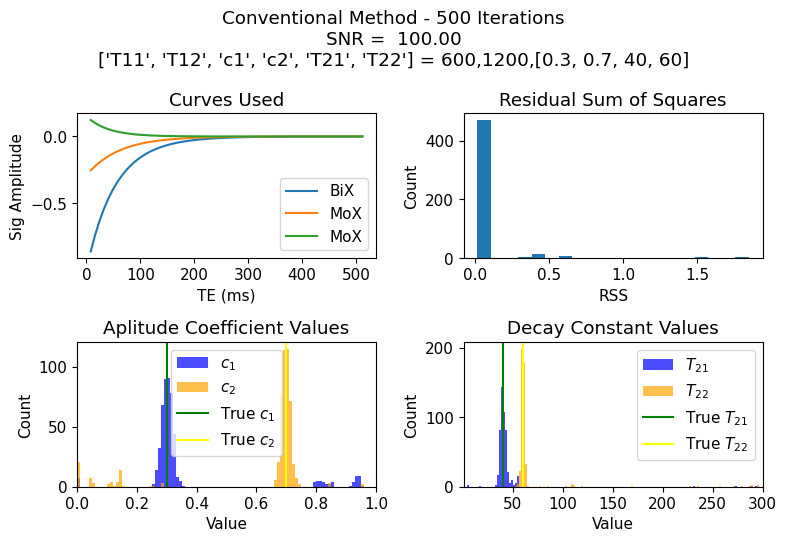

In [295]:
fig, ax = plt.subplots(2, 2, figsize=(8,5.5), tight_layout=True)
fig.suptitle(f"Conventional Method - {var_reps} Iterations\nSNR = {SNR_value : 0.2f}\n{ParamTitle_6p} = {T11},{T12},{true_params}")

labels = get_param_list(S_biX_6p)
lb, ub = get_func_bounds(S_biX_6p)

MSEMat, varMat, sqBMat = calc_MSE(param_est_cvn, true_params)

for ii in range(len(X_array_real)):
    ax[0,0].plot(TE_DATA, signal_array[ii,:], label = X_array_real[ii])
ax[0,0].legend()
ax[0,0].set_xlabel("TE (ms)")
ax[0,0].set_ylabel("Sig Amplitude")
ax[0,0].set_title("Curves Used")

ax[0,1].hist(x = fval_cvn, bins = 20)
ax[0,1].set_xlabel('RSS')
ax[0,1].set_ylabel('Count')
ax[0,1].set_title("Residual Sum of Squares")

bin_array = np.arange(0, 1, 0.01)
ax[1,0].hist(x=param_est_cvn[:,0], bins=bin_array, color='b', label = r'$c_{1}$', alpha = 0.7)
ax[1,0].hist(x=param_est_cvn[:,1], bins=bin_array, color='orange', label = r'$c_{2}$', alpha = 0.7)
ax[1,0].axvline(x = true_params[0], label = r'True $c_{1}$', color='g')
ax[1,0].axvline(x = true_params[1], label = r'True $c_{2}$', color='yellow')
ax[1,0].legend()
ax[1,0].set_xlabel('Value')
ax[1,0].set_ylabel('Count')
ax[1,0].set_title("Aplitude Coefficient Values")
ax[1,0].set_xlim([lb[0],ub[0]])

bin_array = np.arange(0, ub[-1], 2)
bin_array = np.arange(0, ub[-1], 2)
ax[1,1].hist(x=param_est_cvn[:,2], bins=bin_array, color='b', label = r'$T_{21}$', alpha = 0.7)
ax[1,1].hist(x=param_est_cvn[:,3], bins=bin_array, color='orange', label = r'$T_{22}$', alpha = 0.7)
ax[1,1].axvline(x = true_params[2], label = r'True $T_{21}$', color='g')
ax[1,1].axvline(x = true_params[3], label = r'True $T_{22}$', color='yellow')
ax[1,1].legend()
ax[1,1].set_xlabel('Value')
ax[1,1].set_ylabel('Count')
ax[1,1].set_title("Decay Constant Values")
ax[1,1].set_xlim([lb[-1],ub[-1]])

(1.0, 300.0)

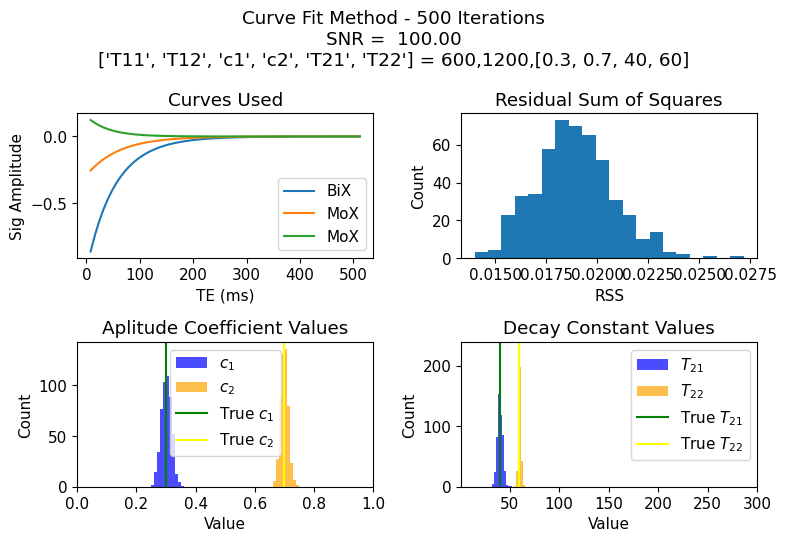

In [296]:
fig, ax = plt.subplots(2, 2, figsize=(8,5.5), tight_layout=True)
fig.suptitle(f"Curve Fit Method - {var_reps} Iterations\nSNR = {SNR_value : 0.2f}\n{ParamTitle_6p} = {T11},{T12},{true_params}")

labels = get_param_list(S_biX_6p)
lb, ub = get_func_bounds(S_biX_6p)

MSEMat, varMat, sqBMat = calc_MSE(param_est_cF, true_params)

for ii in range(len(X_array_real)):
    ax[0,0].plot(TE_DATA, signal_array[ii,:], label = X_array_real[ii])
ax[0,0].legend()
ax[0,0].set_xlabel("TE (ms)")
ax[0,0].set_ylabel("Sig Amplitude")
ax[0,0].set_title("Curves Used")

ax[0,1].hist(x = fval_cF, bins = 20)
ax[0,1].set_xlabel('RSS')
ax[0,1].set_ylabel('Count')
ax[0,1].set_title("Residual Sum of Squares")

bin_array = np.arange(0, 1, 0.01)
ax[1,0].hist(x=param_est_cF[:,0], bins=bin_array, color='b', label = r'$c_{1}$', alpha = 0.7)
ax[1,0].hist(x=param_est_cF[:,1], bins=bin_array, color='orange', label = r'$c_{2}$', alpha = 0.7)
ax[1,0].axvline(x = true_params[0], label = r'True $c_{1}$', color='g')
ax[1,0].axvline(x = true_params[1], label = r'True $c_{2}$', color='yellow')
ax[1,0].legend()
ax[1,0].set_xlabel('Value')
ax[1,0].set_ylabel('Count')
ax[1,0].set_title("Aplitude Coefficient Values")
ax[1,0].set_xlim([lb[0],ub[0]])

bin_array = np.arange(0, ub[-1], 2)
ax[1,1].hist(x=param_est_cF[:,2], bins=bin_array, color='b', label = r'$T_{21}$', alpha = 0.7)
ax[1,1].hist(x=param_est_cF[:,3], bins=bin_array, color='orange', label = r'$T_{22}$', alpha = 0.7)
ax[1,1].axvline(x = true_params[2], label = r'True $T_{21}$', color='g')
ax[1,1].axvline(x = true_params[3], label = r'True $T_{22}$', color='yellow')
ax[1,1].legend()
ax[1,1].set_xlabel('Value')
ax[1,1].set_ylabel('Count')
ax[1,1].set_title("Decay Constant Values")
ax[1,1].set_xlim([lb[-1],ub[-1]])